# Is extraterrestrial dust a significant source of iron to the ocean?

We added a new field passed from the atmosphere to the ocean in CESM: climatological Fe wet deposition flux rate at the surface from the WACCM/CARMA model simulation. This was produced with horizontal resolution of 1.9x2.4 degrees and averaged from 2004-2014 from simulations described by Brooke et al.(2017).  

The oxidation state of the meteoric Fe is uncertain and perhaps two scenarios should be considered:

1. We treat the Fe from the attached fluxes as bioavailable iron (Fe$^{II}$) (e.g. Fe2(SO4)3, as recent lab experiments suggest). Then the total flux to the ocean would include that over open waters + seasonal sea ice. 

1. We consider that extraterrestrial Fe as non-bioavailable Fe$^{III}$ iron. Here Fe fluxes over open waters would not be available for ocean biology. Only those over seasonal seaice would count since FeIII would be reduced to FeII by reaction with iodine in ice, both during winter and sunlit periods. 

In all cases, sea ice accumulates iron deposition and releases material upon melt. "Scavenging" coefficients are uncertain; the current implementation treats exterrestrial iron like dust.

ice_aerosol.F90 specifies scavenging coefficients for 6 aerosols; exterrestrial iron is number 4:
```fortran
  data kscav   / .03_dbl_kind, .20_dbl_kind,&

       .02_dbl_kind,.02_dbl_kind,.01_dbl_kind,.01_dbl_kind /

  data kscavsi / .03_dbl_kind, .20_dbl_kind,&

       .02_dbl_kind,.02_dbl_kind,.01_dbl_kind,.01_dbl_kind /
```

Brooke, J., W. Feng, J. Diego Carrillo-Sanchez, G. Mann, A. James, C. Bardeen, J. Plane, Meteoric smoke deposition in the polar regions: a comparison of measurements with global atmospheric models (2017): J. Geophys. Res. Atmos., 122, https://doi.org/10.1002/2017JD027143.

In [1]:
%matplotlib inline
import os
from subprocess import call
from glob import glob

import cftime
import pandas as pd
import xarray as xr
import numpy as np

import time

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import plottools as pt
import gridtools as gt
import project as P
import calc

os.environ['CARTOPY_USER_BACKGROUNDS'] = '/glade/work/mclong/natural-earth-img'
USER = os.environ['USER']

In [2]:
from dask.distributed import Client
from dask_jobqueue import PBSCluster
import dask

Nnodes = 2
dask.config.set({'distributed.dashboard.link':'http://localhost:{port}/status'})


# Lots of arguments to this command are set in ~/.config/dask/jobqueue.yaml
cluster = PBSCluster(queue='regular',
                     cores = 36,
                     processes = 9,
                     memory = '100GB',                     
                     project = 'NCGD0033',
                     walltime = '04:00:00',
                     local_directory=f'/glade/scratch/{USER}/dask-tmp')
client = Client(cluster)


cluster.scale(9*Nnodes)

while not cluster.running_jobs:
    print('...',end='')
    time.sleep(30)

client    

...........................

Client Scheduler: tcp://10.148.10.13:41766 Dashboard: http://localhost:8787/status,Cluster Workers: 18 Cores: 72 Memory: 199.98 GB


In [3]:
import cesm
import yaml
import logging

logging.basicConfig(level=logging.ERROR)

with open('collections.yml') as f:
    spec = yaml.load(f)

cases = []
dss = {}
for d_src,d_attrs in spec['monthly'].items():
    print(f'{d_src}: {d_attrs["description"]}')
    cases.append(d_src)
    opnds = d_attrs['open_dataset']
    dss[d_src] = cesm.open_dataset(**opnds)


CTRL: Default model configuration
IceFe-allsol: Default model configuration w/ seaice_fe_bioavail_frac = 1
XT-FE: Extraterrestrial Fe


In [4]:
budgets = {}
for d_src,d_attrs in spec['budgets'].items():
    print(f'{d_src}: {d_attrs["description"]}')
    cases.append(d_src)
    opnds = d_attrs['open_dataset']
    budgets[d_src] = cesm.open_dataset(**opnds)          

CTRL: Default model configuration
XT-FE: Extraterrestrial Fe


How big are these datasets?

In [5]:
dss['CTRL'].nbytes/1024**3 # GB

57.65483336523175

## does the Fe dep flux match the data we put into the model?

Here's the extraterrestrial flux dataset:

In [6]:
extterfe_path = '/glade/work/mclong/cesm_cases/extraterr-fe/data/forcing'
extterfe_file = 'waccm_carma_unab_43tpd_fe_wetdep_rate.nc'
dsi = xr.open_dataset(f'{extterfe_path}/{extterfe_file}',decode_coords=False,decode_times=False)
dsi['area'] = gt.compute_grid_area_lonlat(dsi.lon,dsi.lat)

mw_fe = 55.845
umolm2yr_to_kgm2s = mw_fe * 1e-6 * 1e-3 / 86400. / 365. # (mw g/mol)(1mol/10^6 umol)(1kg/10^3g)(1y/365d)(1d/86400s)
dsi['EXTTERFE'] = dsi.dustsw.isel(plev=0) * umolm2yr_to_kgm2s
dsi.EXTTERFE.attrs['units'] = 'kg m-2 s-1'
dsi

<xarray.Dataset>
Dimensions:   (lat: 96, lon: 144, plev: 1, time: 12)
Coordinates:
  * lon       (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat       (lat) float32 -90.0 -88.10526 -86.210526 ... 88.10526 90.0
  * plev      (plev) float32 1000.0
  * time      (time) float32 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0
Data variables:
    dustsw    (time, plev, lat, lon) float64 ...
    area      (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    EXTTERFE  (time, lat, lon) float64 1.1e-17 1.1e-17 ... 7.517e-17 7.517e-17
Attributes:
    institution:    University of Leeds, UK
    source:         WACCM/CARMA
    project_id:     EU CODITA
    experiment_id:  Brooke et al. (JGR, 2017), unab-43 (35.4 t d−1 unablated ...
    contact:        Wuhu Feng and John Plane (w.feng@leeds.ac.uk and J.M.C.Pl...

<br><br>

Integrate globally

In [7]:
fe_input_xyint = (dsi.EXTTERFE * dsi.area).sum(['lat','lon'])
fe_input_xyint.values

array([0.15506708, 0.18536609, 0.18965009, 0.18108336, 0.17509897,
       0.17283549, 0.18215719, 0.17107623, 0.15681373, 0.13676159,
       0.11447494, 0.11961699])

<br><br>
Integrate the fluxes passed to the ocean from the coupler.  We don't expect an exact match here for two reasons: (1) the original dataset was regridded to the f09 grid using a bilinear method (not conservative); (2) the material deposited on sea ice is stored in the ice, so `SEAICE_XTFE_FLUX_CPL` is temporally lagged.

In [8]:
((dss['XT-FE'].ATM_XTFE_FLUX_CPL + dss['XT-FE'].SEAICE_XTFE_FLUX_CPL) * dss['XT-FE'].TAREA).sum(['nlat','nlon']).values / 1000.



array([0.12087805, 0.13141998, 0.12623264, 0.11201999, 0.10670702,
       0.11243431, 0.12375617, 0.12699963, 0.11980734, 0.10468946,
       0.09292857, 0.10174699])

Looks like we're in the right ballpark, so I am happy to believe that the model has done what I intended.

## what is the magnitude of the new iron flux?

Compute annual means

In [10]:
keep_list = ['IRON_FLUX','FG_CO2','photoC_TOT_zint','ATM_XTFE_FLUX_CPL','SEAICE_XTFE_FLUX_CPL','time','time_bound']
dsa = {}
for case,ds in dss.items():
    dsa[case] = calc.compute_ann_mean(ds.drop([v for v in ds.variables if v not in keep_list]))    

What's the new iron flux look like?

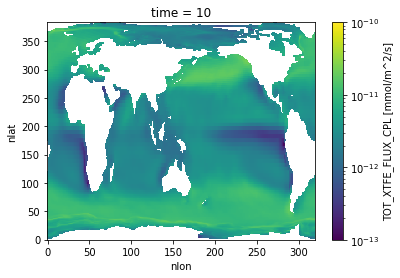

In [11]:
np.warnings.filterwarnings("ignore",category = RuntimeWarning)

# convert the units to mmol/m^2/s
gcm2s_to_mmolm2s = 1e3 * 1e4 / mw_fe
dsa['XT-FE']['TOT_XTFE_FLUX_CPL'] = (dsa['XT-FE'].ATM_XTFE_FLUX_CPL + dsa['XT-FE'].SEAICE_XTFE_FLUX_CPL)*gcm2s_to_mmolm2s
dsa['XT-FE']['TOT_XTFE_FLUX_CPL'].attrs['units'] = 'mmol/m^2/s'

p = dsa['XT-FE'].TOT_XTFE_FLUX_CPL.plot(norm=colors.LogNorm(vmin=1e-13, vmax=1e-10),vmin=1e-13,vmax=1e-10)

Plot annual mean Fe deposition flux from control

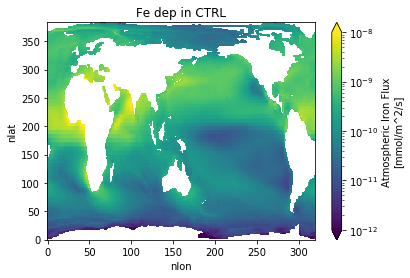

In [12]:
p = dsa['CTRL'].IRON_FLUX.plot(norm=colors.LogNorm(vmin=1e-12, vmax=1e-8),vmin=1e-12,vmax=1e-8)
h = plt.gca().set_title('Fe dep in CTRL')

So the maximum of the new flux is a couple orders of magnitude smaller that `IRON_FLUX` (i.e., atmospheric deposition) in the CTRL experiment. 


Let's consider the new flux as fractional increase in iron deposition relative to the control.  What's that look like?

First define a lambda function to reuse later.

In [13]:
frac_change = lambda v: ((dsa['XT-FE'][v] - dsa['CTRL'][v])/dsa['CTRL'][v])

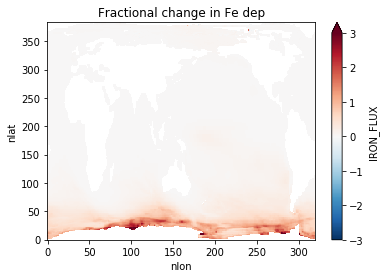

In [14]:
frac_change('IRON_FLUX').plot(vmin=-3,vmax=3,cmap='RdBu_r') #norm=colors.LogNorm(vmin=1e-12, vmax=1e-8))
h = plt.gca().set_title('Fractional change in Fe dep')

So over most of the ocean, the new XTFe flux has a pretty small impact. Over the Southern Ocean, however, it has increased Fe deposition by as much as 400%.
<br><br>

Plot the absolute difference:

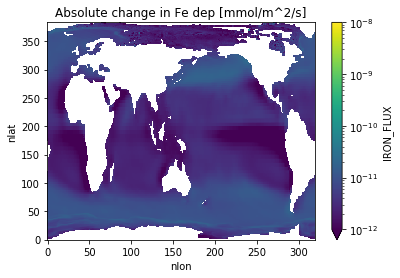

In [15]:
p = (dsa['XT-FE'].IRON_FLUX - dsa['CTRL'].IRON_FLUX).plot(norm=colors.LogNorm(vmin=1e-12, vmax=1e-8),vmin=1e-12,vmax=1e-8)
h = plt.gca().set_title('Absolute change in Fe dep [mmol/m^2/s]')

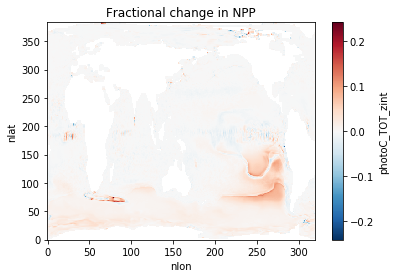

In [16]:
frac_change('photoC_TOT_zint').plot()
h = plt.gca().set_title('Fractional change in NPP')

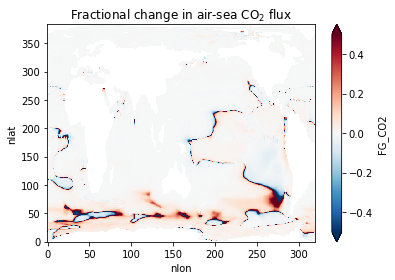

In [17]:
frac_change('FG_CO2').plot(vmin=-0.5,vmax=0.5,cmap='RdBu_r')
h = plt.gca().set_title('Fractional change in air-sea CO$_2$ flux')

Let's have a quick look at the seasonal cycle of a few quantities in the Southern Ocean.

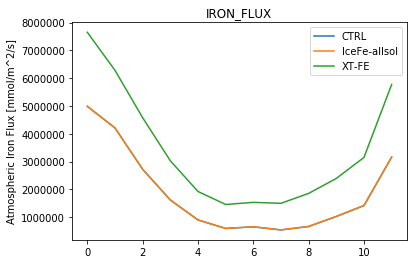

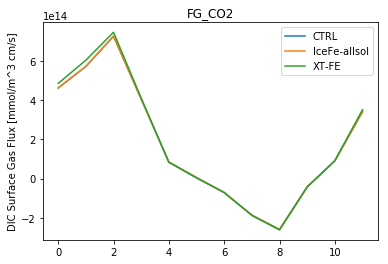

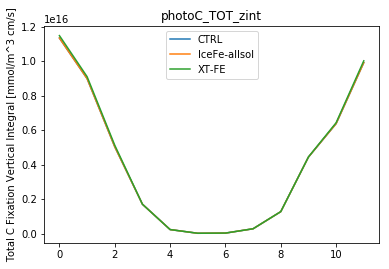

In [18]:
for v in ['IRON_FLUX','FG_CO2','photoC_TOT_zint']:
    fig = plt.figure()
    for case,ds in dss.items():
        ds_int = (ds[v] * ds.TAREA).where(ds.TLAT<-60.).sum(['nlat','nlon'])
        plt.plot(ds_int.values,label=case)
        plt.gca().set_ylabel(f'{ds[v].attrs["long_name"]} [{ds[v].attrs["units"]}]')
    plt.gca().set_title(v)
    plt.legend()

So the impact of XTFe is pretty small. How does it compare to the vertical flux into the upper ocean?



## Compute physical transport of Fe across 100 m.

In [19]:
# indices in z coords
k_w = int(np.where(budgets['CTRL'].z_w >= 100e2)[0][0])
k_t = int(k_w - 1)
print(f'k_w = {k_w}')
print(f'k_t = {k_t}')

dz_w = budgets['CTRL'].dz.isel(z_t=k_w).values
dz_t = budgets['CTRL'].dz.isel(z_t=np.arange(0,k_t+1,1))

k_w = 10
k_t = 9


In [20]:
Fe_flux_at_100m_adv = budgets['CTRL'].WT_Fe.isel(z_w_top=k_w) * dz_w * 1e-2 # tend normalization: mmol/m^3/s --> mmol/m^2/s
Fe_flux_at_100m_dia = (-1.0) * budgets['CTRL'].DIA_IMPVF_Fe.isel(z_w_bot=k_t) * 1e-2 # mmol/m^3 cm/s --> mmol/m^2/s
Fe_flux_at_100m_adv.attrs['units'] = 'mmol/m^2/s'
Fe_flux_at_100m_dia.attrs['units'] = 'mmol/m^2/s'

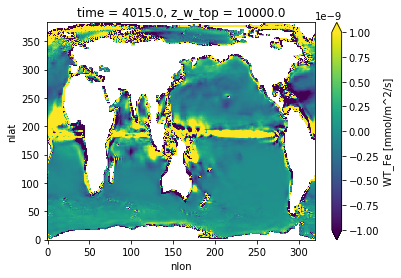

In [21]:
p = Fe_flux_at_100m_adv.plot(vmin=-1e-9,vmax=1e-9)

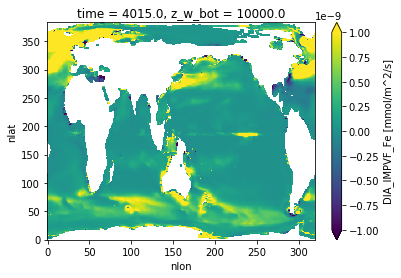

In [22]:
p = Fe_flux_at_100m_dia.plot(vmin=-1e-9,vmax=1e-9)

In [23]:
lat = budgets['CTRL'].TLAT[:,0]

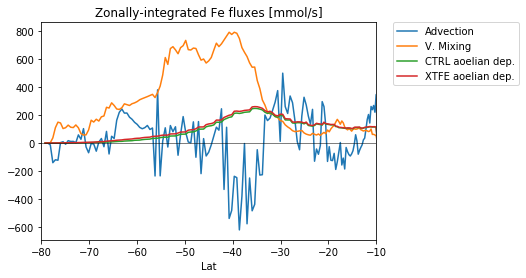

In [24]:
p = plt.plot(lat,(Fe_flux_at_100m_adv.isel(time=0) * budgets['CTRL'].TAREA * 1e-4).where(budgets['CTRL'].TLAT<-10).sum('nlon'),label='Advection')
p = plt.plot(lat,(Fe_flux_at_100m_dia.isel(time=0) * budgets['CTRL'].TAREA * 1e-4).where(budgets['CTRL'].TLAT<-10).sum('nlon'),label='V. Mixing')
p = plt.plot(lat,(dsa['CTRL'].IRON_FLUX.isel(time=0) * budgets['CTRL'].TAREA * 1e-4).where(budgets['CTRL'].TLAT<-10).sum('nlon'),label='CTRL aoelian dep.')
p = plt.plot(lat,(dsa['XT-FE'].IRON_FLUX.isel(time=0) * budgets['CTRL'].TAREA * 1e-4).where(budgets['CTRL'].TLAT<-10).sum('nlon'),label='XTFE aoelian dep.')

plt.xlim((-80,-10))
plt.xlabel('Lat')
h = plt.gca().set_title('Zonally-integrated Fe fluxes [mmol/s]')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
p = plt.axhline(0,color='k',linewidth=0.5)

So the indications are that Fe supply is strongly dominated by vertical mixing, which explains the modest changes in NPP etc.